### Analysis of CycIF data from PTCL

In [1]:
# Import librarires
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import re

# Create anndata and scanpy
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import bbknn

# Import custom functions
import wget

#### Import data

In [52]:
# Set working directory
# Laptop
WD = "/Users/aj/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma/20190214_Datadump/"
# HMS
#WD = "C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma/20190214_Datadump/"

os.chdir(WD)
data = pd.read_csv('PTCLCycle1to9_CytMedian_nonorm.csv', delimiter=',', index_col=0)
meta = pd.read_csv('meta.csv', delimiter=',',index_col=0)

In [53]:
data.head()

,DAPI,BACK,CD2,TCR,DAPI02,CD4,CD3D,CD7,DAPI03,CD43,...,BACK.1,BCL6,DAPI12,EBVLMP,BACK.2,CD31,DAPI13,CD16,BACK.3,PSTAT3
cell_id,,,,,,,,,,,,,,,,,,,,,
1_1,134,62,87,1201,182,105,47,20,211,59,...,9,89,190,122,6,4,171,84,4,13
1_2,15,5,19,140,12,11,9,5,38,2,...,2,19,48,10,1,2,29,9,2,3
1_3,14,6,27,378,22,11,7,3,38,10,...,1,11,43,16,2,0,35,26,0,0
1_4,36,10,22,490,49,11,6,7,126,6,...,2,13,95,19,2,0,60,18,0,2
1_5,57,24,64,1117,68,32,22,8,218,54,...,2,23,145,50,2,0,96,51,0,0


In [54]:
meta.head()

,core,patient,StudyID,Tissue,DX,DX_trim,code
cell_id,,,,,,,
1_1,1,1,Tonsil,Tonsil,Control,Control,1
1_2,1,1,Tonsil,Tonsil,Control,Control,1
1_3,1,1,Tonsil,Tonsil,Control,Control,1
1_4,1,1,Tonsil,Tonsil,Control,Control,1
1_5,1,1,Tonsil,Tonsil,Control,Control,1


In [70]:
# custom normalization
file_url = 'https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/py_scripts/mi_pp_normalize.py'
exec(open(wget.download(file_url)).read())
data = mi_pp_normalize (data)

Applying log transformation and quantile normalization...


In [51]:
# Read
adata = sc.read("adata_ptcl.h5ad")

In [81]:
# Save
adata.write("adata_ptcl.h5ad")

#### Look at the head of data

#### Remove DAPI and background channels

In [71]:
# Drop DAPI
data = data.drop(list(data.filter(regex='DAPI|BACK', axis=1)), axis=1)
data.head()

,CD2,TCR,CD4,CD3D,CD7,CD43,ALK,CD45,CD10,KI67,...,CD21,S6P,ERK,TBET,TDT,BCL6,EBVLMP,CD31,CD16,PSTAT3
cell_id,,,,,,,,,,,,,,,,,,,,,
1_1,-0.011393,0.589162,0.174610,0.043100,-0.374257,0.015502,0.080084,0.176558,0.372001,-0.169406,...,-0.176813,-0.164304,-0.116538,0.128775,0.386580,0.293514,0.535619,-0.645705,0.264398,-0.137168
1_2,-0.348197,0.107484,-0.394797,-0.404718,-0.663823,-0.827373,-0.626629,-0.499802,-0.279067,-1.000000,...,-0.730479,-0.532046,-0.649936,-0.627848,-0.165196,-0.151486,-0.263972,-0.822852,-0.372990,-0.630434
1_3,-0.270409,0.330085,-0.394797,-0.472805,-0.770524,-0.426546,-0.764429,0.041806,-0.249225,-0.268424,...,-0.408090,-0.752770,-0.779134,-0.454808,-0.184628,-0.308986,-0.113734,-1.000000,-0.070255,-1.000000
1_4,-0.315744,0.388244,-0.394797,-0.514568,-0.593542,-0.553766,-0.391058,-0.059220,-0.173718,-0.105335,...,-0.552336,-0.505540,-0.649936,-0.220006,-0.098009,-0.260845,-0.058802,-1.000000,-0.175190,-0.766830
1_5,-0.079359,0.572912,-0.125286,-0.162560,-0.565650,-0.006552,-0.155487,0.323727,0.138919,-0.146131,...,-0.264285,-0.325846,-0.379952,0.062140,0.232775,-0.096428,0.250489,-1.000000,0.122004,-1.000000


In [72]:
# Convert to AnnData 
adata = sc.AnnData(data)

In [73]:
# Attach meta data with Anndata
adata.obs = meta

In [74]:
# Remove markers after cycle 10
adata = adata[:,0:29]
# Remove other identified bad markers
columns = ['CD10', 'CD11B', 'CD57']
remove = np.in1d(adata.var_names, columns)
adata = adata[:, ~remove]

In [112]:
# Covert patient column into string 
adata.obs['patient'] = adata.obs['patient'].astype(str)

In [114]:
adata

AnnData object with n_obs × n_vars = 681460 × 26 
    obs: 'core', 'patient', 'StudyID', 'Tissue', 'DX', 'DX_trim', 'code'
    uns: 'pca', 'neighbors', 'StudyID_colors', 'Tissue_colors', 'DX_trim_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

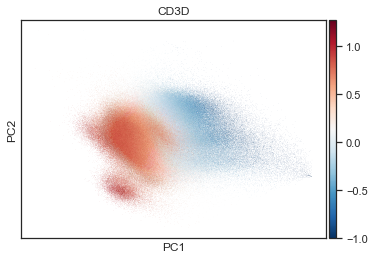

In [77]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CD3D', color_map="RdBu_r")

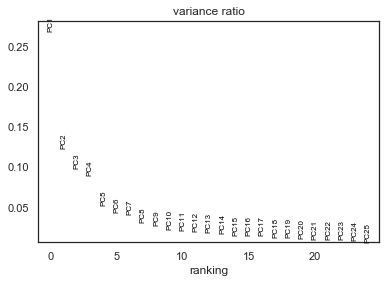

In [78]:
sc.pl.pca_variance_ratio(adata)

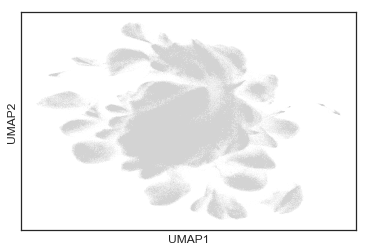

In [79]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata)

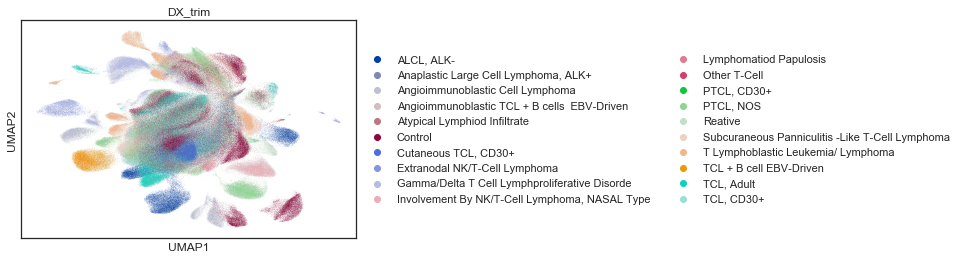

In [84]:
sc.pl.umap(adata,color='DX_trim')

### Subset data

In [116]:
p1 = adata[adata.obs['DX_trim'].isin(['Control'])]

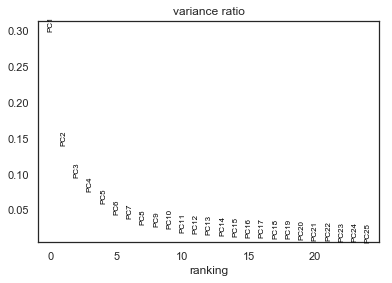

In [117]:
# Calculate PCA
sc.tl.pca(p1, svd_solver='arpack')
sc.pl.pca_variance_ratio(p1)

In [118]:
# UMAP
sc.pp.neighbors(p1, n_neighbors=30, n_pcs=8)
sc.tl.umap(p1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

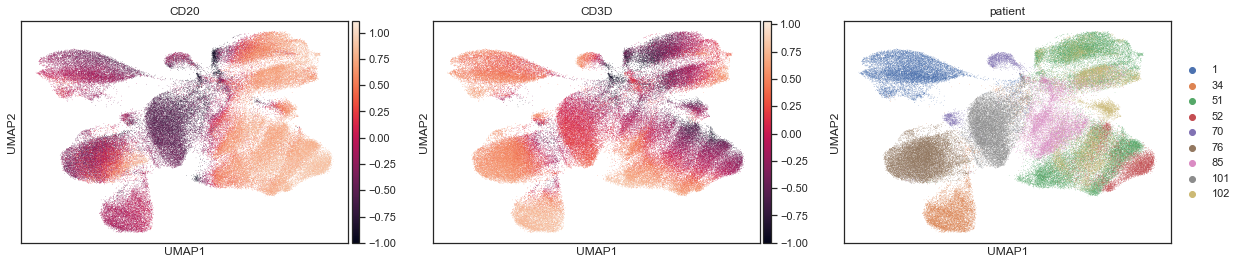

In [120]:
sc.pl.umap(p1, color=['CD20', 'CD3D', 'patient'])

### Batch correction

In [92]:
s1 = adata[adata.obs['cores'].isin(['1'])]
s2 = adata[adata.obs['cores'].isin(['2'])]
s3 = adata[adata.obs['cores'].isin(['3'])]
s4 = adata[adata.obs['cores'].isin(['4'])]
s5 = adata[adata.obs['cores'].isin(['5'])]
s6 = adata[adata.obs['cores'].isin(['6'])]

In [93]:
c = sce.pp.mnn_correct(s1,s2,s3,s4,s5,s6, batch_key='cores')

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 5: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 5: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 5: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 5: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [94]:
p2 = c[0]

In [97]:
# UMAP
sc.pp.neighbors(p2, n_neighbors=30, n_pcs=5)
sc.tl.umap(p2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

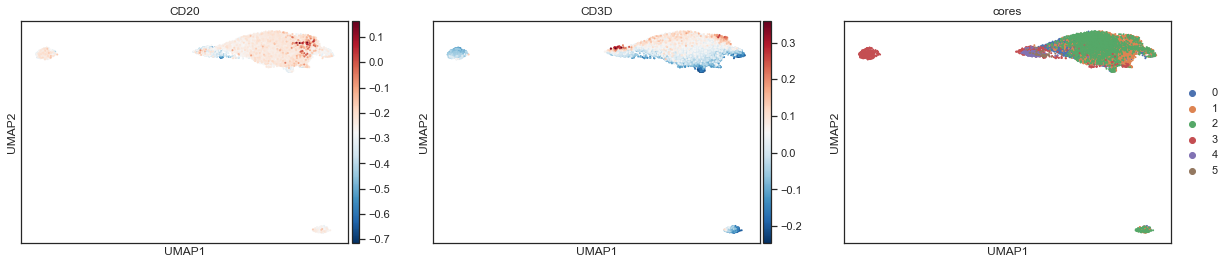

AttributeError: 'NoneType' object has no attribute 'ylim'

In [106]:
#ax.set(ylim=(-1, 1))
sc.pl.umap(p2, color=['CD20', 'CD3D', 'cores'], color_map="RdBu_r")

In [148]:
p = adata[adata.obs['cores'].isin(['1','2','3','4','5','6','7','8','9','10',
                                  '11','12','13','14','15','16','17','18','19','20',
                                  '21','22','23','24','25','26','27','28','29','30',
                                  '31','32','33','34','35','36','37','38','39','40'])]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

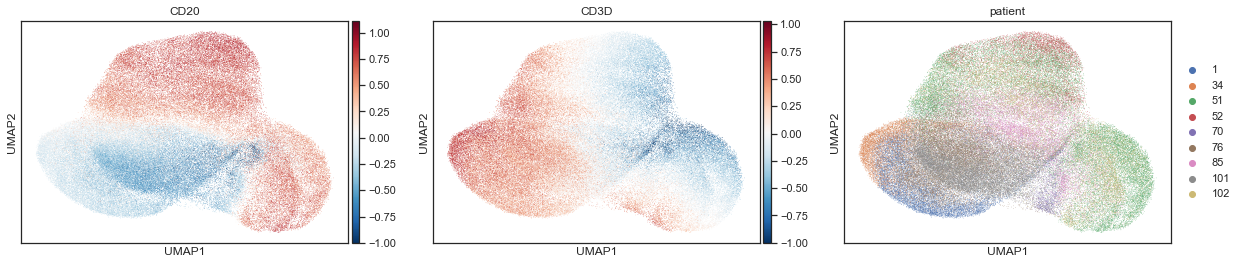

In [121]:
adata_bbknn = bbknn.bbknn(p1, neighbors_within_batch=5, n_pcs=8, copy=True, batch_key='patient')
sc.tl.umap(adata_bbknn)
#sc.tl.louvain(adata_bbknn)

sc.pl.umap(adata_bbknn, color=['CD20', 'CD3D', 'patient'], color_map="RdBu_r")

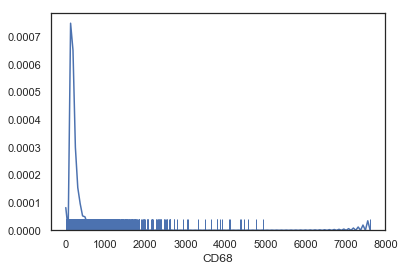

In [44]:
sns.distplot(data['CD68'], hist=False, rug=True)

#### Normalize based on custom methiod

In [45]:
file_url = 'https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/py_scripts/mi_pp_normalize.py'
exec(open(wget.download(file_url)).read())
data_nn = mi_pp_normalize (data)

Applying log transformation and quantile normalization...


In [47]:
# Drop DAPI
data_nn = data_nn.drop(list(data_nn.filter(regex='DAPI|BACK', axis=1)), axis=1)

,CD2,TCR,CD4,CD3D,CD7,CD43,ALK,CD45,CD10,KI67,...,CD21,S6P,ERK,TBET,TDT,BCL6,EBVLMP,CD31,CD16,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.406640,0.231810,-0.61038,-0.245100,-0.39460,-0.35536,-0.410740,-0.058780,-0.990550,-0.075095,...,-0.39021,-0.54668,-0.54125,0.068790,-0.94468,-0.88867,-0.365380,-0.37063,-0.517090,-0.27502
1_2,-0.208120,0.353310,-0.40702,-0.143160,-0.32192,-0.40222,-0.457840,-0.026391,-0.548220,-0.116100,...,-0.34019,-0.43913,-0.62656,0.351130,-0.41090,-0.69078,-0.158590,-0.36016,-0.296570,-0.23356
1_3,-0.345370,0.028613,-0.46394,-0.186560,-0.37300,-0.20602,-0.524310,0.073478,-0.816200,0.071263,...,-0.38670,-0.50294,-0.68652,-0.032020,-0.66349,-0.69435,-0.355140,-0.37063,-0.376790,-0.22695
1_4,-0.120140,0.219100,-0.35657,-0.072530,-0.30623,0.01909,-0.229020,0.155930,-0.260930,-0.051495,...,-0.29164,-0.39117,-0.31303,0.150620,-0.50284,-0.58655,0.217390,-0.34998,-0.121790,-0.17680
1_5,-0.031985,-0.049000,-0.19408,-0.050959,-0.28056,-0.22607,0.057713,0.243970,-0.041982,-0.101010,...,-0.32303,-0.37833,0.12395,-0.061973,-0.20285,-0.45637,0.064211,-0.34009,0.028438,-0.12005


In [49]:
# Convert to AnnData 
adata_n = sc.AnnData(data_nn)

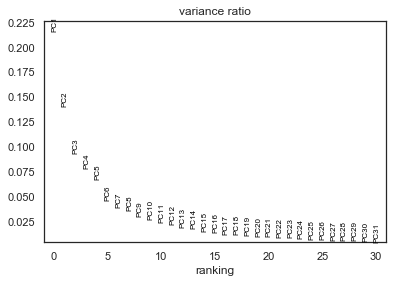

In [50]:
# Calculate PCA
sc.tl.pca(adata_n, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_n)

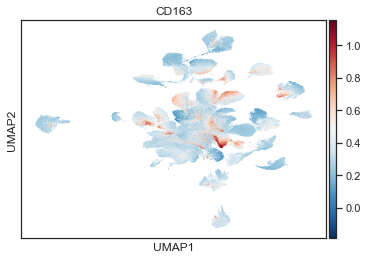

In [52]:
sc.pp.neighbors(adata_n, n_neighbors=30, n_pcs=5)
sc.tl.umap(adata_n)
sc.pl.umap(adata_n, color='CD163', color_map="RdBu_r")

In [ ]:
sc.tl.draw_graph(pdata)
sc.pl.draw_graph(pdata)

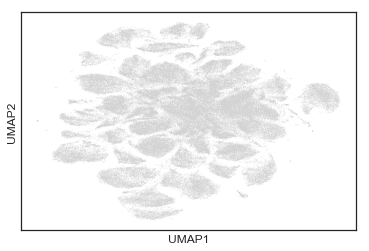

In [57]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=7)
sc.tl.umap(adata)
sc.pl.umap(adata)

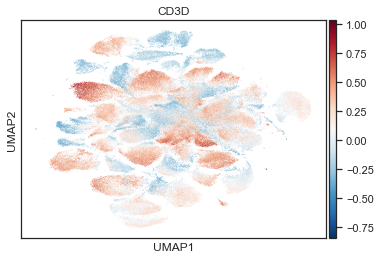

In [58]:
sc.pl.umap(adata,color='CD3D', color_map="RdBu_r")